In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Train a Neural Network to predict the Machine State

A Tensorflow 2.0 Tutorial with Deployment to Tensorflow Serving

We collected some Data from a machine while it was working correctly and when it was not working. We want to train a neural network that can predict whether the machine is running correctly or not.

We are using Tensorflow 2.0 and finally serve the trained model in a production ready Docker.

## Training Data

We have collected some sensor values and have to label them manually (Supervised Learning). We have basically 2 cases:
    
1. Machine is working correctly
2. Machine is not working

Each is in separate log files.

In [2]:
X_0 = pd.read_csv('./TrainingData/notworking.csv')
X_1 = pd.read_csv('./TrainingData/working.csv')

In [3]:
classes = {'notworking': 0,
           'working': 1} # to predict

In [4]:
X_0['label'] = classes['notworking']
X_1['label'] = classes['working']

In [5]:
# put them together in one DataFrame
X_df = pd.concat([X_0, X_1])

In [6]:
X_df.head()

timestamp  ax [m/s²]  ay [m/s²]  az [m/s²]  rx [°/s]  ry [°/s]  \
0  1.579956e+09       9.71      -0.18      -0.92      0.06      0.00   
1  1.579956e+09       9.74      -0.22      -0.95      0.06      0.00   
2  1.579956e+09       9.77      -0.19      -0.97     -0.06     -0.06   
3  1.579956e+09       9.73      -0.17      -0.98     -0.06      0.12   
4  1.579956e+09       9.72      -0.18      -0.93      0.06      0.00   

   rz [°/s]  mx [µT]  my [µT]  mz [µT]  y [°]  r [°]   p [°]  label  
0      0.00   -31.75    11.25    22.69  64.38  85.06  179.06      0  
1      0.06   -31.75    10.56    22.25  64.38  85.06  179.06      0  
2      0.00   -31.38    10.19    23.75  64.38  85.06  179.06      0  
3      0.06   -31.75    10.19    22.69  64.38  85.06  179.06      0  
4      0.06   -31.06    11.00    22.69  64.38  85.06  179.06      0

In [7]:
X_df.groupby('label').count()

timestamp  ax [m/s²]  ay [m/s²]  az [m/s²]  rx [°/s]  ry [°/s]  \
label                                                                   
0            563        563        563        563       563       563   
1            656        656        656        656       656       656   

       rz [°/s]  mx [µT]  my [µT]  mz [µT]  y [°]  r [°]  p [°]  
label                                                            
0           563      563      563      563    563    563    563  
1           656      656      656      656    656    656    656

## Machine Learning

1. Features
2. Labels
3. Build and Train
4. Evaluate
5. Deploy

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras

In [9]:
tf.__version__

'2.0.0'

### Features

In [10]:
features = ['ax [m/s²]', 'ay [m/s²]', 'az [m/s²]']

In [11]:
X = X_df[features].values
X.shape

(1219, 3)

### Labels

In [12]:
y = X_df.loc[:, 'label'].values
y.shape

(1219,)

### Build and train the Model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
model = keras.Sequential([
    keras.layers.Dense(50, input_dim=len(features), activation='relu'),
    keras.layers.Dense(len(classes), activation='softmax')
])

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs=20)

Train on 816 samples
Epoch 1/20
816/816 [==============================] - 1s 753us/sample - loss: 2.0872 - accuracy: 0.2966
Epoch 2/20
816/816 [==============================] - 0s 42us/sample - loss: 0.6096 - accuracy: 0.6679
Epoch 3/20
816/816 [==============================] - 0s 43us/sample - loss: 0.2166 - accuracy: 0.9571
Epoch 4/20
816/816 [==============================] - 0s 41us/sample - loss: 0.1379 - accuracy: 0.9743
Epoch 5/20
816/816 [==============================] - 0s 41us/sample - loss: 0.1093 - accuracy: 0.9779
Epoch 6/20
816/816 [==============================] - 0s 42us/sample - loss: 0.0946 - accuracy: 0.9779
Epoch 7/20
816/816 [==============================] - 0s 41us/sample - loss: 0.0853 - accuracy: 0.9792
Epoch 8/20
816/816 [==============================] - 0s 39us/sample - loss: 0.0792 - accuracy: 0.9804
Epoch 9/20
816/816 [==============================] - 0s 43us/sample - loss: 0.0744 - accuracy: 0.9804
Epoch 10/20
816/816 [==============================

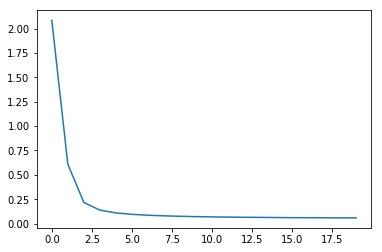

In [17]:
plt.plot(history.history['loss']);

## Model Evaluation

In [18]:
X_test.shape

(403, 3)

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

403/1 - 0s - loss: 0.0380 - accuracy: 0.9826

Test accuracy: 0.98263025


In [20]:
# The Network predicts the probability for every class
y_pred_probs = model.predict(X_test)

In [21]:
# Retranslate to the Class
y_pred = np.argmax(y_pred_probs, axis=1)

In [22]:
assert(y_pred.shape[0] == X_test.shape[0])

### Confusion Matrix

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize it

In [24]:
cm

array([[0.96969697, 0.03030303],
       [0.00487805, 0.99512195]])

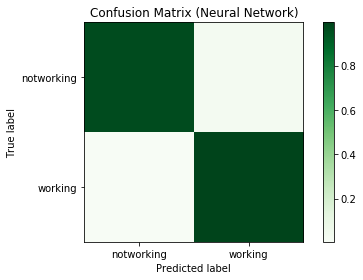

In [25]:
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes.keys(), yticklabels=classes.keys(),
       title='Confusion Matrix (Neural Network)',
       ylabel='True label',
       xlabel='Predicted label');
plt.tight_layout()
plt.savefig('ConfusionMatrix_NN.png', dpi=150)

### Classification Report

In [26]:
print(classification_report(y_test, y_pred, target_names=classes.keys()))

              precision    recall  f1-score   support

  notworking       0.99      0.97      0.98       198
     working       0.97      1.00      0.98       205

   micro avg       0.98      0.98      0.98       403
   macro avg       0.98      0.98      0.98       403
weighted avg       0.98      0.98      0.98       403



## Save the Model

Saves the model to Tensorflow SavedModel for deployment in TensorFlow Serving.

In [27]:
modelversion = '1'
tf.saved_model.save(model, f'./NeuralNetwork/{modelversion}/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./NeuralNetwork/1/assets


Now you can use the model inside a Tensorflow Serving Container

```bash
docker run -it --rm -p 8501:8501 \
    -v "$(pwd)/NeuralNetwork:/models/neuralnetwork" \
    -e MODEL_NAME=neuralnetwork \
    tensorflow/serving
```

Now visit http://localhost:8501/v1/models/neuralnetwork

The REST-API is available, you can POST the sensor values and let it predict the probability:

```bash
curl -d '{"instances": [[-2.45, -0.85,  9.71]]}' \
    -X POST http://localhost:8501/v1/models/neuralnetwork:predict
```

returns the probabilities of the state of the machine:

```json
{
    "predictions": [[0.920448422, 0.0795515254]]
}
```

Which basically means, that the probability, that the machine is not working is around 92%:

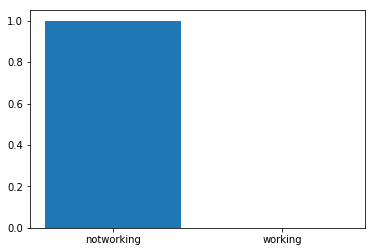

In [30]:
plt.bar(x=range(2), height=y_pred_probs[0], tick_label=list(classes.keys()));

## Conclusion

The trained Neural Network predicts the probability, if the machine is running if you feed in the sensor values. The model can run in a Tensorflow Serving Container and can be deployed to any local machine or cloud service (like Amazon ECS) with literally one line of code.

# Deploy for Production

There are several ways to deploy the trained model. One is to use Amazon Cloud Services like Elastic Container Service.

## Build and Push the Image

Dockerfile

    FROM tensorflow/serving
    COPY /NeuralNetwork /models/neuralnetwork
    ENV MODEL_NAME=neuralnetwork
    EXPOSE 8501
    
Build: `docker build -t mechlabengineering/machine_error_detection .`

Push: `docker push mechlabengineering/machine_error_detection`

Now you will find the model in a container in the official Docker Registry: https://hub.docker.com/r/mechlabengineering/machine_error_detection

## Use with Amazon Elastic Container Service (Amazon ECS) using Fargate

Go to [AWS ECS Cluster Setup](https://eu-central-1.console.aws.amazon.com/ecs/home?region=eu-central-1#/clusters) and setup your Cluster. Don't forget the Load Balancer. When its up and running, grab the [DNS](https://eu-central-1.console.aws.amazon.com/ec2/home?region=eu-central-1#LoadBalancers) of your Load Balancer and use it as Prediction Endpoint, e.g.:

```bash
curl -d '{"instances": [[-2.45, -0.85,  9.71]]}' \
     -X POST http://ec2co-ecsel-1gh18qgiju8gl-1032209297.eu-central-1.elb.amazonaws.com:8501/v1/models/neuralnetwork:predict
```

CC-BY2.0 Licence MechLab Engineering UG, Paul Balzer